<a href="https://colab.research.google.com/github/Cody9494/DSC511-Introduction/blob/main/NLP_Tutorial_02_Text_Pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: **Text Pre-Processing**

In [ ]:
##########################################
# Install the levenshtein python package #
# in order to later use the MED.         #
##########################################

!pip install levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.2 MB/s eta 0:00:00


We will be using the [`20newsgroups`](http://qwone.com/~jason/20Newsgroups/) dataset available within the `sklearn` library.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

In [ ]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. `comp.sys.ibm.pc.hardware` / `comp.sys.mac.hardware`), while others are highly unrelated (e.g `misc.forsale` / `soc.religion.christian`).

In [ ]:
for t in data.target_names:

  print('-', t)

- alt.atheism
- comp.graphics
- comp.os.ms-windows.misc
- comp.sys.ibm.pc.hardware
- comp.sys.mac.hardware
- comp.windows.x
- misc.forsale
- rec.autos
- rec.motorcycles
- rec.sport.baseball
- rec.sport.hockey
- sci.crypt
- sci.electronics
- sci.med
- sci.space
- soc.religion.christian
- talk.politics.guns
- talk.politics.mideast
- talk.politics.misc
- talk.religion.misc


For the purposes of this tutorial, let's focus on the topics of `talk.politics.guns` and `talk.politics.mideast`.

In [ ]:
categories = ['talk.politics.guns', 'talk.politics.mideast']

guns_data    = fetch_20newsgroups(categories=[categories[0]])
mideast_data = fetch_20newsgroups(categories=[categories[1]])

In [ ]:
print(guns_data.data[0])

From: thf2@kimbark.uchicago.edu (Ted Frank)
Subject: Re: Gritz/JBS/Liberty Lobby/LaRouche/Christic Insitute/Libertarian/...
Reply-To: thf2@midway.uchicago.edu
Organization: University of Chicago
Lines: 27

In article <C5L2BC.C2x.1@cs.cmu.edu> rubinoff+@cs.cmu.edu (Robert Rubinoff) writes:
>In article <93105.230230U23590@uicvm.uic.edu> <U23590@uicvm.uic.edu> writes:
>>Note that Bo Gritz was on the Populist party ticket with David
>>Duke (for veep) in 1988 until he found out that Duke was leading
>>he ticket, when he withdrew his candidacy.  

That's a revisionist account of what happened.  Gritz was well-aware
of Duke's presence on the ticket.  Given that Gritz is not at all shy
about associating and promoting other white supremacists (such as the
Christian Identity movement or Willis Carto), whatever reasons Gritz
had to leave the ticket had nothing to do with Duke's presence.

>>So Gritz gave up his
>>chance to be Vice President of the US just to aviod supporting
>>Duke.
>
>I'd hardly

## Step 1: Basic Cleaning
Before we start, let's do a basic cleaning, consisting of two steps.

1. Let's uncontract the documents, converting short forms like `We'll` into `We will`.

2. Let's remove / convert any `URL` or `Email` prior to the tokenization.

#### 1. Uncontract the Documents

RegexPal: https://www.regexpal.com/?fam=138395

In [ ]:
def uncontract(text):
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)

    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)

    return text

*Use of `tqdm` package to track the process*.

In [ ]:
from tqdm import tqdm
import re

guns_data     = [uncontract(t) for t in guns_data.data]
mideast_data  = [uncontract(t) for t in mideast_data.data]

#### 2. Convert `URL` and `Email`

In [ ]:
#################################################
# URL regex that starts with `http` or `https`: #
#################################################

url_regex_1 = r'^https?:\\/\\/(?:www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$'

#############################################
# URL regex that doesn't start with `http`: #
#############################################

url_regex_2 = r'^[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$'

Replace URL occurrences in our data with `URL`.

In [ ]:
guns_data     = [re.sub(url_regex_1, 'URL', t) for t in tqdm(guns_data)]
guns_data     = [re.sub(url_regex_2, 'URL', t) for t in tqdm(guns_data)]

mideast_data  = [re.sub(url_regex_1, 'URL', t) for t in tqdm(mideast_data)]
mideast_data  = [re.sub(url_regex_2, 'URL', t) for t in tqdm(mideast_data)]


100%|██████████| 546/546 [00:00<00:00, 222663.10it/s]

100%|██████████| 546/546 [00:00<00:00, 286691.28it/s]

100%|██████████| 564/564 [00:00<00:00, 291077.58it/s]

100%|██████████| 564/564 [00:00<00:00, 397110.53it/s]


Replace email occurrences in our data with `EMAIL`.

In [ ]:
email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'

guns_data     = [re.sub(email_regex, 'EMAIL', t) for t in tqdm(guns_data)]
mideast_data  = [re.sub(email_regex, 'EMAIL', t) for t in tqdm(mideast_data)]


100%|██████████| 546/546 [00:00<00:00, 14066.81it/s]

100%|██████████| 564/564 [00:00<00:00, 11426.85it/s]


## Step 2: Tokenization

The first step is to tokenize the documents per-class into words i.e. tokens. To do so, we will be using the `NLTK` package, and specifically, the `word_tokenize` function from the `nltk.tokenize` module.

In [ ]:
import re, string, nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
##################################
# Download the necessery NLTK    #
# resources for tokenization and #
# stopword corpus.               #
##################################

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Tokenize the documents for each class.

In [ ]:
s = "this is an example sentence. I am from U.S.A., specifically Texas."

word_tokenize(s)

['this',
 'is',
 'an',
 'example',
 'sentence',
 '.',
 'I',
 'am',
 'from',
 'U.S.A.',
 ',',
 'specifically',
 'Texas',
 '.']

In [ ]:
from tqdm import tqdm

guns_tokens     = [word_tokenize(t) for t in tqdm(guns_data)]
mideast_tokens  = [word_tokenize(t) for t in tqdm(mideast_data)]


100%|██████████| 546/546 [00:01<00:00, 309.80it/s]

100%|██████████| 564/564 [00:03<00:00, 148.00it/s]


In [ ]:
', '.join(guns_tokens[0])

"From, :, EMAIL, (, Ted, Frank, ), Subject, :, Re, :, Gritz/JBS/Liberty, Lobby/LaRouche/Christic, Insitute/Libertarian/, ..., Reply-To, :, EMAIL, Organization, :, University, of, Chicago, Lines, :, 27, In, article, <, EMAIL, >, EMAIL, (, Robert, Rubinoff, ), writes, :, >, In, article, <, EMAIL, >, <, EMAIL, >, writes, :, >, >, Note, that, Bo, Gritz, was, on, the, Populist, party, ticket, with, David, >, >, Duke, (, for, veep, ), in, 1988, until, he, found, out, that, Duke, was, leading, >, >, he, ticket, ,, when, he, withdrew, his, candidacy, ., That, 's, a, revisionist, account, of, what, happened, ., Gritz, was, well-aware, of, Duke, 's, presence, on, the, ticket, ., Given, that, Gritz, is, not, at, all, shy, about, associating, and, promoting, other, white, supremacists, (, such, as, the, Christian, Identity, movement, or, Willis, Carto, ), ,, whatever, reasons, Gritz, had, to, leave, the, ticket, had, nothing, to, do, with, Duke, 's, presence, ., >, >, So, Gritz, gave, up, his, >, 

In [ ]:
', '.join(guns_tokens[1])

"From, :, EMAIL, (, Kirk, Hays, ), Subject, :, Re, :, Nazi, memoribilia, Nntp-Posting-Host, :, taos, Organization, :, Intel, Supercomputer, Systems, Division, Lines, :, 38, In, article, <, cmay.734085409, @, helium, >, ,, EMAIL, (, Christopher, C, May, ), writes, :, |, >, In, <, EMAIL, >, EMAIL, (, Michael, P., Brininstool, ), writes, :, |, >, |, >, >, Swatikas, were, also, common, in, American, Indian, markings/painted, walls, etc, ., Is, |, >, >, it, the, Swastika, that, is, bad, ?, |, >, |, >, Just, want, to, back, this, up, with, a, personal, anecdote, ., My, grandparents, |, >, have, a, Navajo, rug, made, in, the, 1920, 's, ,, which, they, received, in, trade, |, >, from, the, weaver, while, living, in, Flagstaff, ,, Arizona, ., The, decorative, motif, |, >, consists, of, 4, large, black, swastikas, ,, one, in, each, corner, ., What, 's, more, ,, the, |, >, color, scheme, is, black, ,, white, ,, and, red, ., To, the, casual, glance, it, would, |, >, undoubtedly, appear, to, be, a,

In [ ]:
import itertools

################################################
# From the previous cell, guns_tokens contains #
# a list of lists of the per-document tokens.  #
# We need to merge those into a single list.   #
################################################

guns_tokens     = list(itertools.chain.from_iterable(guns_tokens))
mideast_tokens  = list(itertools.chain.from_iterable(mideast_tokens))

In [ ]:
guns_tokens[:10]

['From', ':', 'EMAIL', '(', 'Ted', 'Frank', ')', 'Subject', ':', 'Re']

We can generate the vocabulary `V` of each dataset by taking the unique tokens from the token lists:

In [ ]:
print('Number of Unique Gun Tokens:    ', len(set(guns_tokens)))
print('Number of Unique Mideast Tokens:', len(set(mideast_tokens)))

Number of Unique Gun Tokens:     21051
Number of Unique Mideast Tokens: 19384


The total number of tokens correspond to the number of type instances from `V` in our data:

In [ ]:
print('Number of Gun Tokens:    ', len(guns_tokens))
print('Number of Mideast Tokens:', len(mideast_tokens))

Number of Gun Tokens:     280169
Number of Mideast Tokens: 347982


Let's take a look at the most frequent tokens for each dataset:

In [ ]:
from collections import Counter

print('Gun Tokens:\n')

for t, f in Counter(guns_tokens).most_common(10):

  print('{0:25} {1}'.format(t, f))

print()

print('Mideast Tokens:\n')

for t, f in Counter(mideast_tokens).most_common(10):

  print('{0:25} {1}'.format(t, f))

Gun Tokens:

--                        14876
>                         9787
,                         9674
.                         9158
the                       8773
:                         6077
*                         5030
of                        4719
to                        4713
a                         3734

Mideast Tokens:

,                         15447
the                       14274
.                         13585
>                         9263
of                        7934
to                        6725
and                       6170
:                         5298
in                        4706
a                         3823


Looking at the most frequent tokens in both newsgroup topics, we can see that the majority consists of punctuations like `--` and `>`, and common words (i.e. stopwords) like `the`, `of`, and `to`.

We need to properly normalize the identified tokens in order to capture more clear information about the topics. The normalization step will significantly reduce the dimensionality of the vocabulary, and help us understand better the corpus.

## Step 3: Normalization

In [ ]:
#########################################
# Define an informative function to     #
# monitor the dimensionality of our     #
# data compared to the raw / uncleaned. #
#########################################

def dimensionality_info(gun, mideast):

  print('Number of Gun Tokens:    ', len(gun),     '/', len(guns_tokens))
  print('Number of Mideast Tokens:', len(mideast), '/', len(mideast_tokens))
  print()
  print('Unique Gun Tokens:       ', len(set(gun)), '/', len(set(guns_tokens)))
  print('Unique Mideast Tokens:   ', len(set(mideast)), '/', len(set(mideast_tokens)))
  print()
  print('|V|/|Tokens|:            ', len(set(gun)) / len(set(guns_tokens)))
  print('|V|/|Tokens|:            ', len(set(mideast)) / len(set(mideast_tokens)))

#### Lowercase

Convert all the tokens to lowercase.

In [ ]:
"Demetris".lower()

'demetris'

In [ ]:
"Demetris".upper()

'DEMETRIS'

In [ ]:
"demetris".capitalize()

'Demetris'

In [ ]:
gun_clean_tokens     = [t.lower() for t in guns_tokens]
mideast_clean_tokens = [t.lower() for t in mideast_tokens]

In [ ]:
dimensionality_info(gun_clean_tokens, mideast_clean_tokens)

Number of Gun Tokens:     280169 / 280169
Number of Mideast Tokens: 347982 / 347982

Unique Gun Tokens:        18341 / 21051
Unique Mideast Tokens:    16888 / 19384

|V|/|Tokens|:             0.8712650230392855
|V|/|Tokens|:             0.8712340074288073


#### Remove Punctuation

Remove all the tokens that consist only of punctiuation characters e.g. `--` or `>`.

In [ ]:
import string

###################################################
# We will be using the `string.punctuation`       #
# set which contains all the possible characters. #
###################################################

print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Use the `filter` function intergrated in python, to identify the tokens that are all digits or all punctuation.

The `filter` accepts a filtering function, in our case we define this function on-the-go using a `lambda`.

In [ ]:
gun_punctuations = list(
    filter(
        lambda t: all(c.isdigit() or c in string.punctuation for c in t),
        gun_clean_tokens
    )
)

mideast_punctuations = list(
    filter(
        lambda t: all(c.isdigit() or c in string.punctuation for c in t),
        mideast_clean_tokens
    )
)

Let's print the most common uninformative tokens (all punctuation or digits):

In [ ]:
print('Gun Punctuation:\n')

for t, f in Counter(gun_punctuations).most_common(10): print('{0:25} {1}'.format(t, f))

print()

print('Mideast Punctuation:\n')

for t, f in Counter(mideast_punctuations).most_common(10): print('{0:25} {1}'.format(t, f))

Gun Punctuation:

--                        14876
>                         9787
,                         9674
.                         9158
:                         6077
*                         5030
)                         3160
(                         2969
''                        2065
?                         1878

Mideast Punctuation:

,                         15447
.                         13585
>                         9263
:                         5298
--                        3278
)                         2655
(                         2561
|                         2466
''                        2442
*                         2215


Now, filter the per-topic tokens by keeping those that are not in the punctuation token sets identified previously.

In [ ]:
len(gun_punctuations)

82256

In [ ]:
gun_punctuations     = set(gun_punctuations)
mideast_punctuations = set(mideast_punctuations)

In [ ]:
gun_clean_tokens     = [t for t in tqdm(gun_clean_tokens) if t not in gun_punctuations]
mideast_clean_tokens = [t for t in tqdm(mideast_clean_tokens) if t not in mideast_punctuations]


100%|██████████| 280169/280169 [00:00<00:00, 3469012.05it/s]

100%|██████████| 347982/347982 [00:00<00:00, 3615484.81it/s]


In [ ]:
dimensionality_info(gun_clean_tokens, mideast_clean_tokens)

Number of Gun Tokens:     197913 / 280169
Number of Mideast Tokens: 273523 / 347982

Unique Gun Tokens:        17040 / 21051
Unique Mideast Tokens:    15970 / 19384

|V|/|Tokens|:             0.8094627333618355
|V|/|Tokens|:             0.8238753611225753


#### Remove Stop-Words

To remove the tokens that are stop-words, we will be using the `stopwords` corpora from `NLTK`.

In [ ]:
', '.join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
########################################
# Let's define a regex that matches    #
# any of the stopword entries in text. #
########################################

stop_word_regex = '|'.join(['^{}$'.format(s) for s in stopwords.words('english')])

In [ ]:
stop_word_regex

"^i$|^me$|^my$|^myself$|^we$|^our$|^ours$|^ourselves$|^you$|^you're$|^you've$|^you'll$|^you'd$|^your$|^yours$|^yourself$|^yourselves$|^he$|^him$|^his$|^himself$|^she$|^she's$|^her$|^hers$|^herself$|^it$|^it's$|^its$|^itself$|^they$|^them$|^their$|^theirs$|^themselves$|^what$|^which$|^who$|^whom$|^this$|^that$|^that'll$|^these$|^those$|^am$|^is$|^are$|^was$|^were$|^be$|^been$|^being$|^have$|^has$|^had$|^having$|^do$|^does$|^did$|^doing$|^a$|^an$|^the$|^and$|^but$|^if$|^or$|^because$|^as$|^until$|^while$|^of$|^at$|^by$|^for$|^with$|^about$|^against$|^between$|^into$|^through$|^during$|^before$|^after$|^above$|^below$|^to$|^from$|^up$|^down$|^in$|^out$|^on$|^off$|^over$|^under$|^again$|^further$|^then$|^once$|^here$|^there$|^when$|^where$|^why$|^how$|^all$|^any$|^both$|^each$|^few$|^more$|^most$|^other$|^some$|^such$|^no$|^nor$|^not$|^only$|^own$|^same$|^so$|^than$|^too$|^very$|^s$|^t$|^can$|^will$|^just$|^don$|^don't$|^should$|^should've$|^now$|^d$|^ll$|^m$|^o$|^re$|^ve$|^y$|^ain$|^aren$

In [ ]:
stop_word_regex += "|^EMAIL$|^email$|^URL$|^url$"

In [ ]:
#####################################
# Compile the regex to RegEx object #
# for the `re` python package.      #
#####################################

stop_word_regex = re.compile(stop_word_regex)

In [ ]:
gun_stop_words     = list(filter(stop_word_regex.match, gun_clean_tokens))
mideast_stop_words = list(filter(stop_word_regex.match, mideast_clean_tokens))

Let's plot some wordclouds to observe the frequency of the stopwords in each of the newsgroup topics.

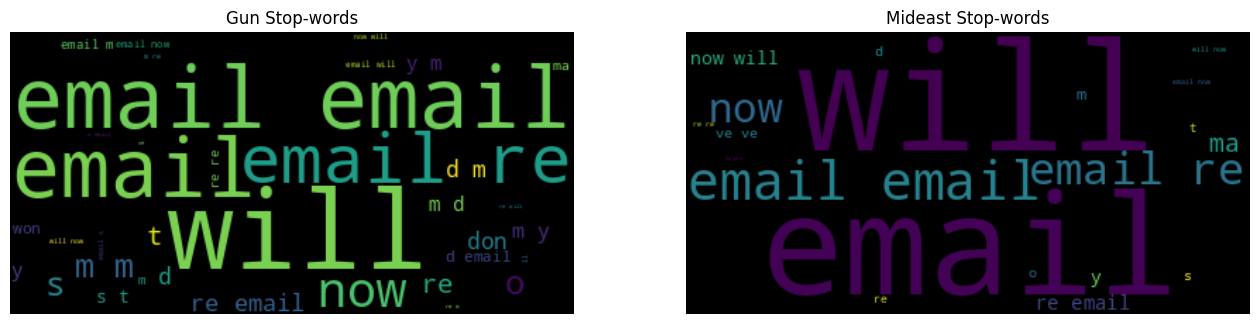

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

wordcloud_1_sw = WordCloud().generate(' '.join(gun_stop_words))

axes[0].imshow(wordcloud_1_sw, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title('Gun Stop-words')

wordcloud_2_sw = WordCloud().generate(' '.join(mideast_stop_words))

axes[1].imshow(wordcloud_2_sw, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title('Mideast Stop-words')

plt.show()

From what we can see, there is not much difference in the frequency of stopwords between the two topics.

In [ ]:
gun_stop_words     = set(gun_stop_words)
mideast_stop_words = set(mideast_stop_words)

In [ ]:
gun_clean_tokens     = [t for t in tqdm(gun_clean_tokens) if t not in gun_stop_words]
mideast_clean_tokens = [t for t in tqdm(mideast_clean_tokens) if t not in mideast_stop_words]


100%|██████████| 197913/197913 [00:00<00:00, 3206917.11it/s]

100%|██████████| 273523/273523 [00:00<00:00, 3483743.72it/s]


Let's take a look at the resulted token frequencies after we have removed the stopwords.

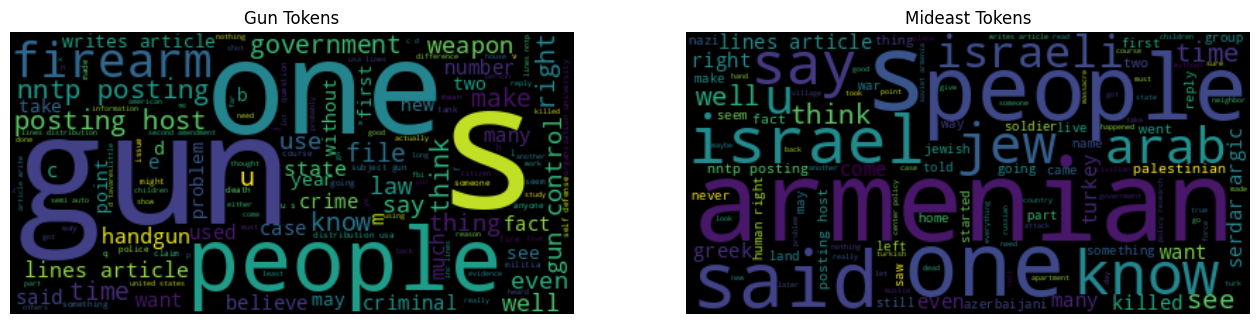

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

wordcloud_1_sw = WordCloud().generate(' '.join(gun_clean_tokens))

axes[0].imshow(wordcloud_1_sw, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title('Gun Tokens')

wordcloud_2_sw = WordCloud().generate(' '.join(mideast_clean_tokens))

axes[1].imshow(wordcloud_2_sw, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title('Mideast Tokens')

plt.show()

Now, we can see the clear separation of content between the `gun-related` and `middle-east-related` newsgroup documents.

In [ ]:
print('Gun Tokens:\n')

for t, f in Counter(gun_clean_tokens).most_common(10): print('{0:25} {1}'.format(t, f))

print()
print('Mideast Tokens:\n')

for t, f in Counter(mideast_clean_tokens).most_common(10): print('{0:25} {1}'.format(t, f))

Gun Tokens:

's                        955
would                     904
gun                       810
people                    655
subject                   583
lines                     563
organization              544
one                       511
writes                    507
article                   474

Mideast Tokens:

's                        1194
people                    984
israel                    870
one                       827
would                     794
turkish                   705
armenian                  654
subject                   653
israeli                   637
armenians                 610


Looking at the above, it is safe to consider the instance of `'s` as a stopword, and remove it from the token lists.

In [ ]:
gun_clean_tokens     = [t for t in gun_clean_tokens if t != "'s"]
mideast_clean_tokens = [t for t in mideast_clean_tokens if t != "'s"]

In [ ]:
dimensionality_info(gun_clean_tokens, mideast_clean_tokens)

Number of Gun Tokens:     106851 / 280169
Number of Mideast Tokens: 141502 / 347982

Unique Gun Tokens:        16904 / 21051
Unique Mideast Tokens:    15832 / 19384

|V|/|Tokens|:             0.8030022326730322
|V|/|Tokens|:             0.8167560874948411


#### Lemmatization & Stemming

Let's apply in separate the `stemming` and `lemmatization` as we learned in class.

##### Stemming

For stemming, we will be using the `PorterStemmer` from the `nltk.stem` package.

In [ ]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [ ]:
############################################
# Here is an example on a series of words. #
############################################

words = ["wait", "waiting", "waited", "waits"]

for w in words:

    root = ps.stem(w)

    print('-', f"{w:8} ->", root)

- wait     -> wait
- waiting  -> wait
- waited   -> wait
- waits    -> wait


In [ ]:
stemmed_gun     = [ps.stem(t) for t in tqdm(gun_clean_tokens)]
stemmed_mideast = [ps.stem(t) for t in tqdm(mideast_clean_tokens)]


100%|██████████| 106851/106851 [00:03<00:00, 30612.64it/s]

100%|██████████| 141502/141502 [00:02<00:00, 52960.11it/s]


In [ ]:
print('Gun Stems:\n')

for t, f in Counter(stemmed_gun).most_common(10): print('{0:25} {1}'.format(t, f))

print()
print('Mideast Stems:\n')

for t, f in Counter(stemmed_mideast).most_common(10): print('{0:25} {1}'.format(t, f))

Gun Stems:

gun                       1229
would                     904
peopl                     657
line                      608
organ                     604
subject                   586
write                     585
use                       541
one                       531
articl                    492

Mideast Stems:

armenian                  1264
peopl                     1000
one                       882
israel                    880
would                     794
isra                      790
turkish                   705
subject                   670
write                     639
jew                       632


In [ ]:
dimensionality_info(stemmed_gun, stemmed_mideast)

Number of Gun Tokens:     106851 / 280169
Number of Mideast Tokens: 141502 / 347982

Unique Gun Tokens:        13439 / 21051
Unique Mideast Tokens:    11648 / 19384

|V|/|Tokens|:             0.6384019761531519
|V|/|Tokens|:             0.6009079653322328


##### Lemmatization

For lemmatization we will use the `WordNetLemmatizer` from the `nltk.stem` module.

This lemmatizer requires the `wordnet` and `omw-1.4` corpora from `NLTK`.

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [ ]:
for w in ['cars', 'car']:

  print('-', lemmatizer.lemmatize(w))

  0%|          | 0/546 [35:38<?, ?it/s]


- car
- car


In [ ]:
lemma_gun     = [lemmatizer.lemmatize(t) for t in tqdm(gun_clean_tokens)]
lemma_mideast = [lemmatizer.lemmatize(t) for t in tqdm(mideast_clean_tokens)]

100%|██████████| 141502/141502 [00:01<00:00, 124682.97it/s]


In [ ]:
print('Gun Lemmas:\n')

for t, f in Counter(lemma_gun).most_common(10): print('{0:25} {1}'.format(t, f))

print()
print('Mideast Lemmas:\n')

for t, f in Counter(lemma_mideast).most_common(10): print('{0:25} {1}'.format(t, f))

Gun Lemmas:

gun                       1229
would                     904
people                    657
line                      608
subject                   584
organization              555
one                       531
writes                    507
article                   492
right                     484

Mideast Lemmas:

armenian                  1264
people                    1000
one                       882
israel                    880
would                     794
israeli                   787
turkish                   705
subject                   661
jew                       632
line                      626


In [ ]:
dimensionality_info(lemma_gun, lemma_mideast)

Number of Gun Tokens:     106851 / 280169
Number of Mideast Tokens: 141502 / 347982

Unique Gun Tokens:        15745 / 21051
Unique Mideast Tokens:    14440 / 19384

|V|/|Tokens|:             0.7479454657735974
|V|/|Tokens|:             0.744944283945522


By observing the results, we can see that the stemming approach reduces the dimenstionality more than the lemmatization.

But this depends on our application. For example, in a case were the suffix of words is important, then the lemmatization would be used.

For this tutorial we will proceed with the `stemmed` tokens.

## Step 4: Clustering

Let's now apply a token clustering using the `Minimum Edit Distance` a.k.a. `Levenshtein` distance, as introduced in class.

Specifically, we will apply a hierarchical clustering to the tokens, creating a dendrogram of adjusent tokens based on their `MED`, and then apply a cutoff to construct the clusters based on a pre-defined `MED` threshold.

To do so, we will be using the `ward` linkage approach by `scipy.cluster.hierarchy` module.

In [ ]:
from scipy.cluster.hierarchy import ward, fcluster

from scipy.spatial.distance import pdist, cdist

In [ ]:
###################################
# We will apply the clustering in #
# all the data, so let's combine  #
# the set of tokens into one.     #
###################################

clean_tokens = stemmed_gun + stemmed_mideast

In [ ]:
print('Number of Tokens:', len(clean_tokens))

Number of Tokens: 248353


In [ ]:
for t, f in Counter(clean_tokens).most_common(10): print('{0:25} {1}'.format(t, f))

would                     1698
peopl                     1657
one                       1413
armenian                  1264
gun                       1260
subject                   1256
line                      1236
write                     1224
organ                     1204
articl                    1059


There exist a significant number of tokens despite our normalization process. In order to further reduce our dimensionality, we can discard tokens with a single observation.

In [ ]:
for t, f in Counter(clean_tokens).most_common()[-10:]:

  print('{0:25} {1}'.format(t, f))

eni                       1
tovfik                    1
kasimov                   1
croatian                  1
cebbar                    1
leygara                   1
pro-forma                 1
perfunctori               1
c-130                     1
geopolit                  1


These tokens do not indicate a topic-related information. Remove tokens that appear only once.

In [ ]:
token_freq = dict(Counter(clean_tokens))

tokens_appeared_once = set([t for t, v in token_freq.items() if v == 1])

In [ ]:
print('Number of Single Appearance Tokens:', len(tokens_appeared_once), '/', len(clean_tokens))

Number of Single Appearance Tokens: 10408 / 248353


In [ ]:
clean_tokens = [t for t in clean_tokens if t not in tokens_appeared_once]

In [ ]:
print('Number of Tokens:', len(clean_tokens))

Number of Tokens: 237945


In [ ]:
print('Unique Tokens (|V|):', len(set(clean_tokens)))

Unique Tokens (|V|): 10296


In [ ]:
clean_tokens = list(set(clean_tokens))

Now, on the remaining unique tokens, let's create a `N x N` distance matrix using the `MED` calculated between token-pairs.

We will use the `pdist` method from the `scipy.spatial.distance` module. This method applies optimization and multi-processing to make the calculations faster and more efficient.

In [ ]:
import numpy

clean_token_array = numpy.array(clean_tokens)

clean_token_array[:3]

array(['stain', 'twin', 'vehicular'], dtype='<U64')

In [ ]:
import numpy

clean_token_array = numpy.array(clean_tokens).reshape(-1, 1)

clean_token_array[:3]

array([['stain'],
       ['twin'],
       ['vehicular']], dtype='<U64')

In [ ]:
from Levenshtein import distance

i = 10
j = 41

print('S1: ', clean_token_array[i][0])
print('S2: ', clean_token_array[j][0])

print('MED:', distance(clean_token_array[i][0], clean_token_array[j][0]))

S1:  rippl
S2:  cocktail
MED: 7


In [ ]:
import numpy

distance_matrix = pdist(
    clean_token_array,
    metric = lambda x, y: distance(x[0], y[0])
)

In [ ]:
distance_matrix

array([2., 8., 3., ..., 7., 5., 7.])

##### Hierarchical Clustering

Now, let's apply the hierarchical clustering over the calculated distance matrix. We will use the `ward` linkage approach.

For more information, please look [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage).



In [ ]:
Z = ward(distance_matrix)

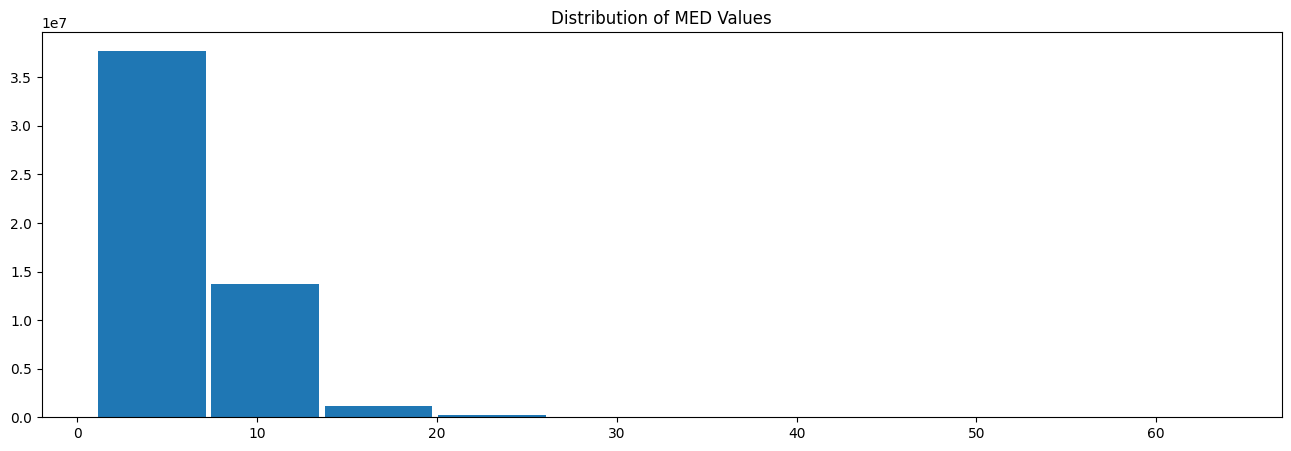

In [ ]:
#####################################
# Plot the distance values in order #
# to naively determine a possible   #
# distance threshold. Remember, the #
# less distance the better.         #
#####################################

plt.figure(figsize=(16, 5))

plt.hist(distance_matrix, rwidth=0.95)

plt.title('Distribution of MED Values')

plt.show()

In order to visualize how the hierarchical clustering works, let's print a dendrogram of the distances (MED) between tokens.

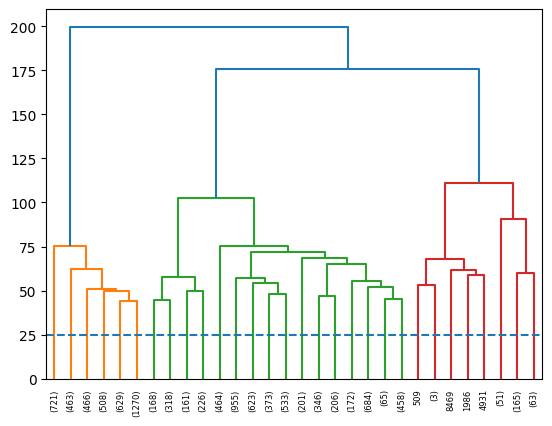

In [ ]:
from scipy.cluster.hierarchy import dendrogram

#####################################
# Because of the significant number #
# of tokens, we apply the `lastp`   #
# truncation.                       #
#####################################

dendrogram(
    Z,
    leaf_rotation  = 90,
    leaf_font_size = 6,
    truncate_mode  = 'lastp'
)

plt.hlines(25, 0, 1000, linestyle='--')

plt.show()

In [ ]:
#############################
# Let's apply the cutoff on #
# a threshold of MED = 10   #
#############################

clusters = fcluster(Z, t = 5, criterion='distance')

In [ ]:
print('Number of Clusters:', len(set(clusters)), '/', len(clean_tokens))

Number of Clusters: 2599 / 10296


In [ ]:
clusters

array([ 198,  515, 2142, ...,  392, 1849,  486], dtype=int32)

In [ ]:
###############################
# Define a cluster dictionary #
###############################

cluster_dict = {}

for i, c in enumerate(clusters):

  ##############################
  # Initialize a cluster array #
  ##############################

  if c not in cluster_dict: cluster_dict[c] = []

  ########################################
  # Populate the cluster with the tokens #
  # and their initial frequency.         #
  ########################################

  cluster_dict[c] += [clean_tokens[i] for k in range(token_freq[clean_tokens[i]])]

In [ ]:
token_to_cluster = {}

for c in cluster_dict:

  for t in cluster_dict[c]:

    token_to_cluster[t] = c

In [ ]:
for c in sorted(
    cluster_dict.keys(),
    key     = lambda c: len(cluster_dict[c]),
    reverse = True
)[:3]:

  print(f'Cluster {c}')
  print()

  for t in sorted(set(cluster_dict[c])): print('- {0:35} {1}'.format(t, token_freq[t]))
  print()
  print('- {0:35} {1}'.format('Total Entries:', len(cluster_dict[c])))
  print()

Cluster 504

- fide                                3
- fine                                49
- five                                55
- gibe                                3
- give                                297
- given                               134
- hide                                55
- hike                                5
- ike                                 4
- lake                                17
- life                                178
- like                                928
- line                                1236
- lite                                3
- live                                497
- mike                                45
- mikem                               2
- mine                                60
- nice                                76
- nile                                6
- nine                                28
- pike                                2
- pile                                17
- pipe                                6
- pix

## Analysis: Compare `Gun` and `Mideast` Tokens

Let's compare the frequency of observation between tokens as they appear in the `gun` and `mideast` datasets.

In [ ]:
##############################################
# Define an informative function to view the #
# information of frequencies between the two #
# sets of tokens passed as input.            #
##############################################

def comparison_info(pos, neg, desc=None, n=10):

  print(f'{desc.capitalize()} only in Gun News:')
  print()

  p_u_freq = dict(Counter(pos))
  n_u_freq = dict(Counter(neg))

  only_pos = set(pos).difference(set(neg))
  only_neg = set(neg).difference(set(pos))
  common   = set(pos).intersection(set(neg))

  for u in sorted(only_pos, key=lambda t: p_u_freq[t], reverse=True)[:n]: print('- {0:35} {1}'.format(u, p_u_freq[u]))

  print()
  print(f'{desc.capitalize()} only in Mideast News:')
  print()

  for u in sorted(only_neg, key=lambda t: n_u_freq[t], reverse=True)[:n]: print('- {0:35} {1}'.format(u, n_u_freq[u]))

  print()
  print(f'{desc.capitalize()} common in Gun and Mideast Tweets:')
  print()

  print('{0:37} {1:10} {2:10}'.format('Token', 'Gun', 'Mideast'))
  print('------------------------------------------------------------')

  for u in sorted(common, key=lambda t: p_u_freq[t] + n_u_freq[t], reverse=True)[:n]:

    print('- {0:35} {1:<10} {2:<10}'.format(u, p_u_freq[u], n_u_freq[u]))

In [ ]:
comparison_info(
  stemmed_gun,
  stemmed_mideast,
  desc = 'Stems',
  n    = 10
)

Stems only in Gun News:

- handgun                             255
- waco                                155
- batf                                150
- atf                                 143
- cop                                 101
- nra                                 92
- rkba                                80
- jason                               73
- semi-auto                           72
- kratz                               71

Stems only in Mideast News:

- armenian                            1264
- turkish                             705
- arab                                500
- armenia                             363
- turk                                361
- greek                               329
- serdar                              265
- argic                               262
- palestinian                         243
- azerbaijani                         190

Stems common in Gun and Mideast Tweets:

Token                                 Gun        Mideast   
-------

In [ ]:
gun_token_clusters     = [str(token_to_cluster[t]) for t in stemmed_gun if t in token_to_cluster]
mideast_token_clusters = [str(token_to_cluster[t]) for t in stemmed_mideast if t in token_to_cluster]

Next, let's look at the cluster frequencies.

In [ ]:
comparison_info(
  gun_token_clusters,
  mideast_token_clusters,
  desc = 'Clusters',
  n    = 10
)

Clusters only in Gun News:

- 850                                 107
- 1184                                87
- 181                                 48
- 1435                                46
- 2240                                38
- 803                                 37
- 1228                                35
- 824                                 32
- 306                                 30
- 237                                 28

Clusters only in Mideast News:

- 942                                 1643
- 1459                                713
- 870                                 395
- 325                                 303
- 863                                 293
- 1946                                136
- 1213                                131
- 178                                 119
- 1552                                103
- 1373                                100

Clusters common in Gun and Mideast Tweets:

Token                                 Gun        Mideast   
--

In [ ]:
gun_diff     = set(gun_token_clusters).difference(mideast_token_clusters)
mideast_diff = set(mideast_token_clusters).difference(gun_token_clusters)

In [ ]:
top_5_gun     = Counter([c for c in gun_token_clusters if c in gun_diff]).most_common(5)
top_5_mideast = Counter([c for c in mideast_token_clusters if c in mideast_diff]).most_common(5)

In [ ]:
top_5_gun     = [int(t[0]) for t in top_5_gun]
top_5_mideast = [int(t[0]) for t in top_5_mideast]

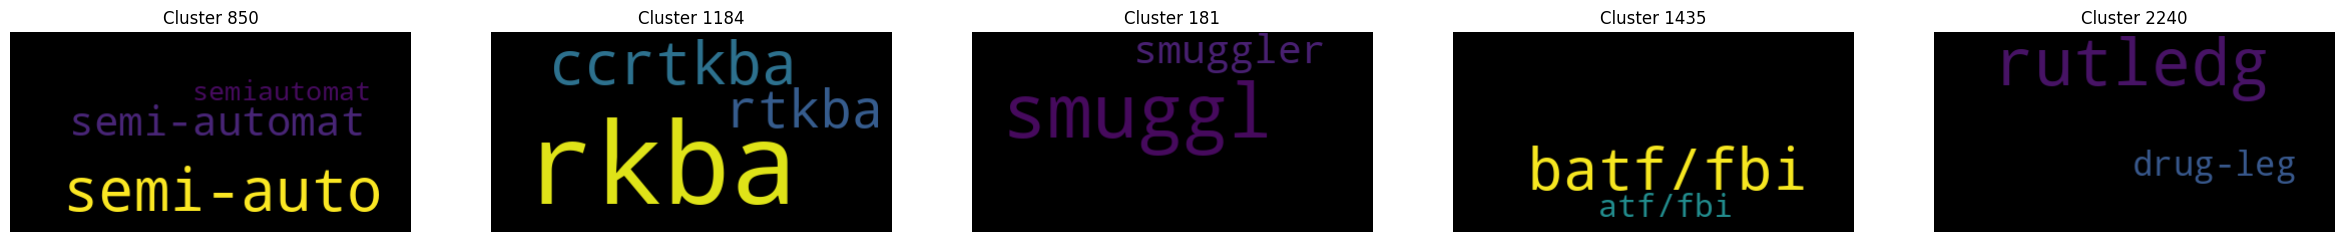

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(30, 10))

for i, c in enumerate(top_5_gun):

  wordcloud_c = WordCloud().generate_from_frequencies(Counter(cluster_dict[c]))

  axes[i].imshow(wordcloud_c, interpolation='bilinear')
  axes[i].axis("off")
  axes[i].set_title('Cluster {0}'.format(c))

plt.show()

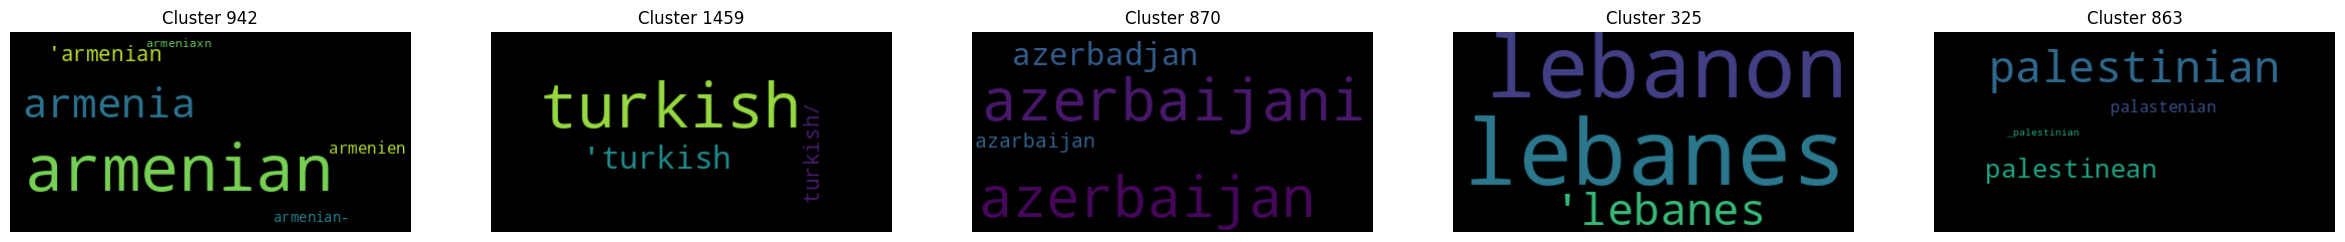

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(30, 10))

for i, c in enumerate(top_5_mideast):

  wordcloud_c = WordCloud().generate_from_frequencies(Counter(cluster_dict[c]))

  axes[i].imshow(wordcloud_c, interpolation='bilinear')
  axes[i].axis("off")
  axes[i].set_title('Cluster {0}'.format(c))

plt.show()